## Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Loading the data set

The data set is assigned to a Pandas data frame.
The `BasketDate` is converted from 'str' to 'datetime'.

In [2]:
df = pd.read_csv('/content/online_retail_combined.csv')

In [4]:
# convert dates in a suitable format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], infer_datetime_format=True)

# add 'Amount' attribute, useful for some additional features on customer's purchase behaviour
df['Amount'] = df['Price'] * df['Quantity']

<ipython-input-4-44855cc0534b>:2: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], infer_datetime_format=True)


# Types of attributes and null values

Description of the dataset

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 9 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067371 non-null  float64       
 6   Customer ID  824364 non-null   float64       
 7   Country      1067371 non-null  object        
 8   Amount       1067371 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 73.3+ MB


Count of null values, for each attribute

In [6]:
df.isnull().sum(axis = 0)

,0
Invoice,0
StockCode,0
Description,4382
Quantity,0
InvoiceDate,0
Price,0
Customer ID,243007
Country,0
Amount,0


All the `Description` missing values are already included in the `Customer ID` ones.
In fact, if we count all the rows where both the attributes are null:

In [7]:
df[df['Customer ID'].isnull() & df['Description'].isnull()].count()

,0
Invoice,4382
StockCode,4382
Description,0
Quantity,4382
InvoiceDate,4382
Price,4382
Customer ID,0
Country,4382
Amount,4382


## Analysis of single attributes
### Invoice
Count number of distinct baskets

In [8]:
bid_counts = df['Invoice'].value_counts()
bid_counts.describe()

,count
count,53628.000000
mean,19.903241
std,41.252573
min,1.000000
25%,2.000000
50%,9.000000
75%,23.000000
max,1350.000000


### Price, Quantity

We noticed there are 6206 price with null cost and 22950 with negative quantity.

In [9]:
# rows with null cost
cost_zero = df['Price'] == 0
df[cost_zero].count()

,0
Invoice,6202
StockCode,6202
Description,1820
Quantity,6202
InvoiceDate,6202
Price,6202
Customer ID,71
Country,6202
Amount,6202


In [10]:
# rows with negative qta
neg_qta = df['Quantity'] < 0
df[neg_qta].count()

,0
Invoice,22950
StockCode,22950
Description,20261
Quantity,22950
InvoiceDate,22950
Price,22950
Customer ID,18744
Country,22950
Amount,22950


In [11]:
df[cost_zero & neg_qta].count()

,0
Invoice,3457
StockCode,3457
Description,768
Quantity,3457
InvoiceDate,3457
Price,3457
Customer ID,0
Country,3457
Amount,3457


We decided to drop these transactions, because they're not relevant for our purposes.

In [12]:
# drop rows with negative quantity
df.drop(df[neg_qta].index, inplace=True)
# drop rows with null cost
df.drop(df[cost_zero].index, inplace=True)

<ipython-input-12-83e31341dde6>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df.drop(df[cost_zero].index, inplace=True)


### InvoiceDate

Some statistics on the dates.

In [13]:
bd_counts = df['InvoiceDate'].dt.date.value_counts()
print("Min date:", str(min(df['InvoiceDate'])))
print("Max date:", str(max(df['InvoiceDate'])))
print("Day with more sales:", str(bd_counts.index[0]))
print("Day with less sales:", str(bd_counts.index[-1]))

Min date: 2009-12-01 07:45:00
Max date: 2011-12-09 12:50:00
Day with more sales: 2010-12-06
Day with less sales: 2010-12-22


<ipython-input-14-6baaa1c9beb7>:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  a = df.groupby(pd.Grouper(key='InvoiceDate', freq='M'))['Invoice'].count()


[]

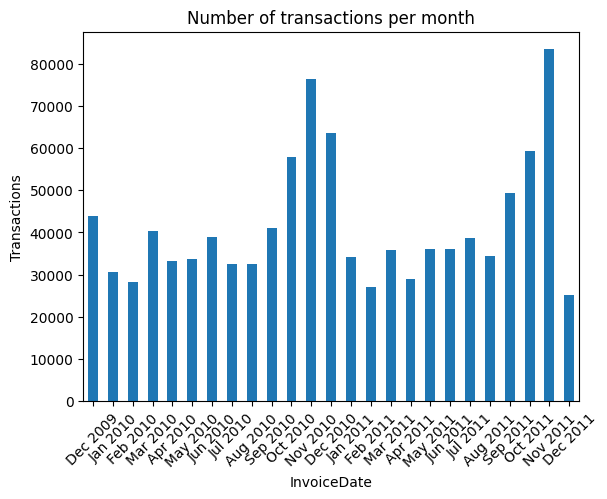

In [14]:
a = df.groupby(pd.Grouper(key='InvoiceDate', freq='M'))['Invoice'].count()
a.index = a.index.strftime('%b %Y')
aplt = a.plot(kind='bar', title='Number of transactions per month', rot=45)

aplt.set_ylabel('Transactions')
aplt.plot()

### Customer ID
How many transactions each customer made?

count     5878.000000
mean       137.044743
std        353.818629
min          1.000000
25%         21.000000
50%         53.000000
75%        142.000000
max      12890.000000
Name: count, dtype: float64


Text(0, 0.5, 'Transactions')

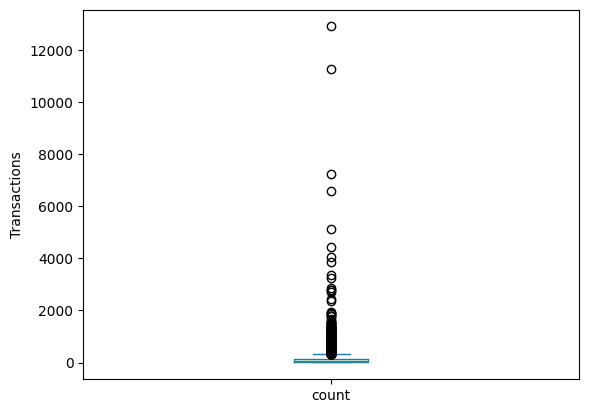

In [15]:
cid_counts = df['Customer ID'].value_counts()
print(cid_counts.describe())
cidplot = cid_counts.plot.box()
cidplot.set_ylabel("Transactions")

As seen before, we have 65080 null values for this attribute.
We removed transactions with null `CustomerID`.

In [16]:
# drop rows with null customerID
df.dropna(subset=['Customer ID'], inplace=True)

# export cleaned dataset for further analysis
df.to_csv(r'/content/clean_df.csv', index=True, header=True)


#### CustomerCountry

<Axes: xlabel='Country'>

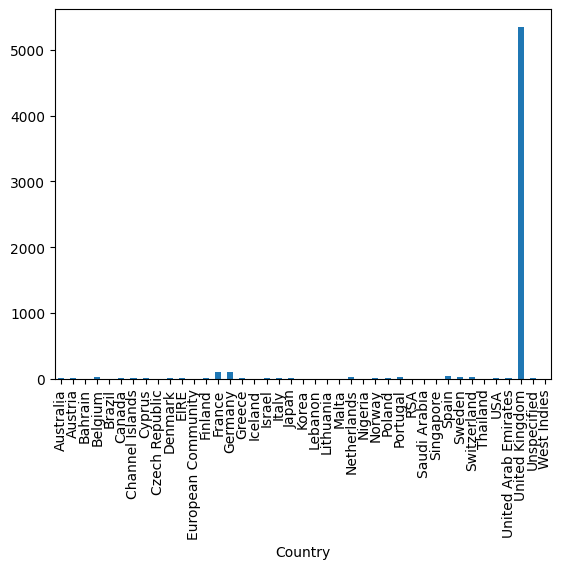

In [17]:
cc_counts = df.groupby(['Country', 'Customer ID']).size().groupby(level=0).size()
cc_counts.plot.bar()

### StockCode, Description

In [18]:
pid_counts = df['StockCode'].value_counts()
print(pid_counts.describe())

best_seller_id = pid_counts.index[0]
best_seller_descr = df.loc[df['StockCode'] == best_seller_id]['Description'].iloc[0]
print("Best seller: {} ({})".format(str(best_seller_id), str(best_seller_descr)))

worst_seller_id = pid_counts.index[-1]
worst_seller_descr = df.loc[df['StockCode'] == worst_seller_id]['Description'].iloc[0]
print("Worst seller: {} ({})".format(str(worst_seller_id), str(worst_seller_descr)))

count    4631.000000
mean      173.947096
std       293.319105
min         1.000000
25%        19.000000
50%        68.000000
75%       198.000000
max      5188.000000
Name: count, dtype: float64
Best seller: 85123A (WHITE HANGING HEART T-LIGHT HOLDER)
Worst seller: 90025B (BAROQUE BUTTERFLY EARRINGS RED)


## Correlation

To calculate pairwise correlation, we transformed some attributes into categorical ones. Due to implementation reasons,
`ProdDescr` had to be treated differently from other attributes.
For this reason, we introduced a dictionary: for each string (key) we assigned an incremental identifier (value).

In [19]:
df_corr = df.copy()

df_corr['StockCode'] = df_corr['StockCode'].astype('category').cat.codes
df_corr.sort_values(by=['StockCode'], inplace=True)
obj = {}
idx = 0
s = ""
for index, row in df_corr.iterrows():
    if row['Description'] != s:
        s = row['Description']
        obj[s] = idx
        idx += 1

Then we replaced all the descriptions with their associated identifier and this way we proceeded to calculate the
pairwise correlation, represented by a heatmap.

In [20]:
df_corr['Description'].replace(obj, inplace=True)

df_corr['Invoice'] = df_corr['Invoice'].astype('category').cat.codes
df_corr['InvoiceDate'] = df_corr['InvoiceDate'].astype('category').cat.codes
df_corr['Customer ID'] = df_corr['Customer ID'].astype('category').cat.codes
df_corr['Country'] = df_corr['Country'].astype('category').cat.codes

<ipython-input-20-202348e3c745>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_corr['Description'].replace(obj, inplace=True)
<ipython-input-20-202348e3c745>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_corr['Description'].replace(obj, inplace=True)


<Axes: >

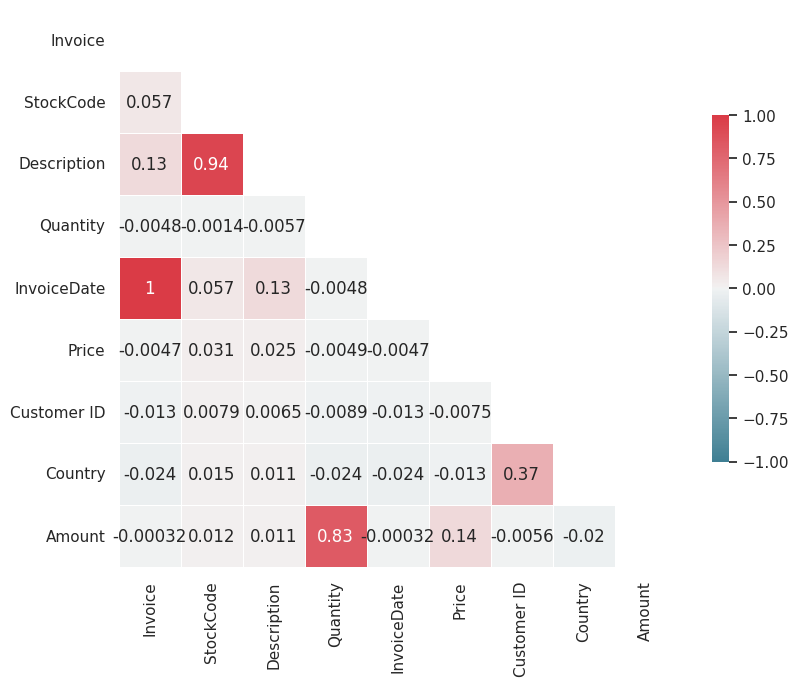

In [22]:
import seaborn as sns

correlation = df_corr.corr()
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(correlation, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(9,9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation, mask=mask, cmap=cmap,annot=True, vmax=1,vmin=-1,
            center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.5})

## Requested features
I, Iu, Imax

In [24]:
df_customer = df.groupby('Customer ID').agg(
    I=('StockCode','count'),
    Iu=('StockCode', 'nunique'))

# Group by Customer ID and Invoice, count the InvoiceDate for each group, then get the maximum count per Customer ID
df_customer['Imax'] = df.groupby(['Customer ID', 'Invoice'])['InvoiceDate'].count().groupby(level=0).max()

Entropy

In [25]:
pos_amounts = df[df['Amount'] >= 0].copy()
p_sum = pos_amounts.groupby('Customer ID')['Amount'].transform('sum')
probs = pos_amounts['Amount']/p_sum
pos_amounts['Entropy'] = -(probs * np.log(probs)) #ss.entropy(probs)
df_customer['Entropy'] = pos_amounts.groupby('Customer ID')['Entropy'].sum()

## New features

Number of Baskets per customer.

In [26]:
# number of baskets per customer
df_customer['BasketNum'] = df.groupby(['Customer ID', 'Invoice']).size().groupby(level=0).size()

Sum and Average expenditure for each customer.

In [27]:
df_group = df.groupby(['Customer ID','Invoice']).agg(BasketSum=('Amount', 'sum'))
df_group = df_group.groupby('Customer ID').agg(BasketMean=('BasketSum', 'mean'), SumExp=('BasketSum', 'sum'))
df_customer['SumExp'] = df_group['SumExp']
df_customer['AvgExp'] = df_group['BasketMean']

## Analysis of new dataset
Combining the required features with the new ones,
we have created a new dataset, useful for subsequent clustering tasks

In [28]:
df_customer.describe()

,I,Iu,Imax,Entropy,BasketNum,SumExp,AvgExp
count,5878.000000,5878.000000,5878.000000,5878.000000,5878.000000,5878.000000,5878.000000
mean,137.044743,81.989112,35.621470,3.693652,6.289384,3018.616737,391.726538
std,353.818629,116.484552,34.142473,1.397080,13.009406,14737.731040,1215.071054
min,1.000000,1.000000,1.000000,0.000000,1.000000,2.950000,2.950000
25%,21.000000,19.000000,14.000000,2.815741,1.000000,348.762500,181.652500
50%,53.000000,45.000000,26.000000,3.711224,3.000000,898.915000,285.070500
75%,142.000000,103.000000,46.000000,4.652588,7.000000,2307.090000,420.570000
max,12890.000000,2550.000000,542.000000,8.900277,398.000000,608821.650000,84236.250000


<Axes: >

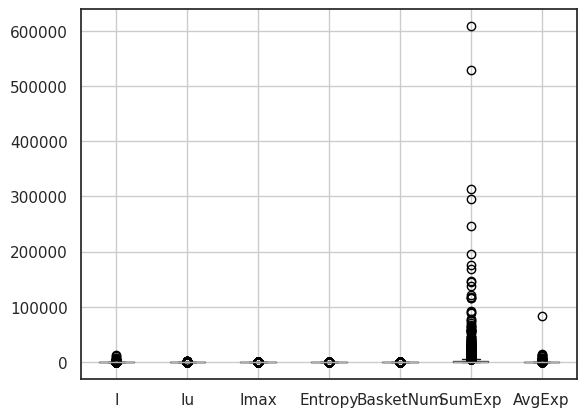

In [29]:
df_customer.boxplot()

## Remove outliers from the new dataset
We exploited the metric of Z-Score.

In [30]:
# use z-score to remove outliers
from scipy.stats import zscore
z_scores = zscore(df_customer)

abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
new_df = df_customer[filtered_entries]

new_df.to_csv(r'/content/new_df.csv', index=True, header=True)

new_df.describe()

,I,Iu,Imax,Entropy,BasketNum,SumExp,AvgExp
count,5649.000000,5649.000000,5649.000000,5649.000000,5649.0000,5649.000000,5649.000000
mean,102.020358,69.296336,32.169056,3.604023,5.0963,1932.125549,343.945401
std,136.359323,75.090363,26.061466,1.323462,6.0061,3330.195153,288.271945
min,1.000000,1.000000,1.000000,0.000000,1.0000,2.950000,2.950000
25%,20.000000,18.000000,14.000000,2.766149,1.0000,335.320000,178.200000
50%,50.000000,42.000000,25.000000,3.654018,3.0000,831.450000,279.129091
75%,126.000000,93.000000,43.000000,4.547036,6.0000,2062.670000,409.945833
max,1132.000000,431.000000,138.000000,6.907336,45.0000,45179.100000,3861.000000


<Axes: >

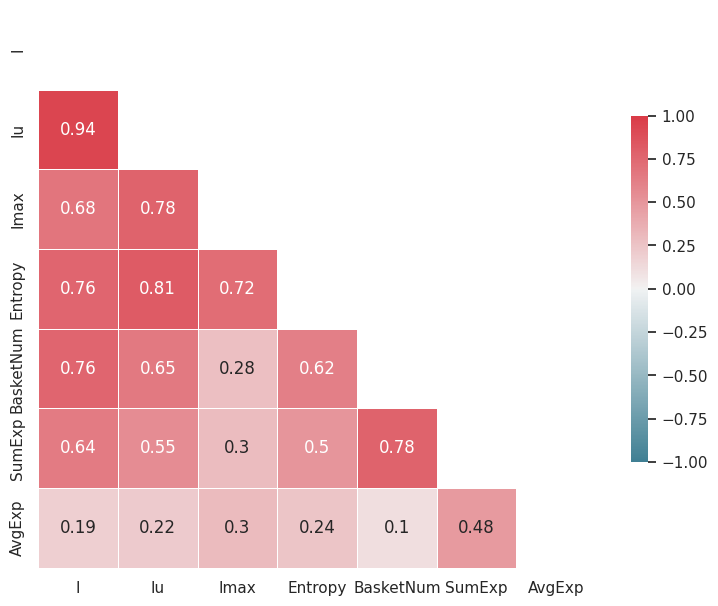

In [32]:
correlation = new_df.corr()
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(correlation, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
fnew, axnew = plt.subplots(figsize=(9,9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation, mask=mask, cmap=cmap,annot=True, vmax=1,vmin=-1, center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.5})